In [1]:
import os
import warnings
import sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing, metrics, model_selection, linear_model
from sklearn import model_selection
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


In [2]:

def eval_metrics(actual, pred):
    return (metrics.precision_score(actual, pred), 
            metrics.recall_score(actual, pred),
            metrics.f1_score(actual, pred))

def plot_learning_curve(model, model_name, scoring, train_sizes):
    fignum = plt.figure(figsize=(6,4))
    ax = plt.gca()
        
    ax.set_title('Curva de Aprendizado (%s)'%model_name)
    ax.set_xlabel("Exemplos do Treino")
    ax.set_ylabel("Score (" + scoring + ")")

    cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0, shuffle=True)
    train_sizes, train_scores, test_scores = model_selection.learning_curve(model,
                                                                            X = xtrain,
                                                                            y = ytrain,
                                                                            cv=cvfold,
                                                                            n_jobs=-1,
                                                                            train_sizes=train_sizes,
                                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    ax.grid()
    ax.plot(train_sizes, train_scores_mean, 'o-', color="darkorange",
                 label="Treino")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="navy",
                 label="Validação-cruzada")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="darkorange")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="navy")
    ax.legend(loc="best")
#     plt.show()
    return fignum

# Leitura dos Dados de Classificação de Vinhos 

In [3]:
df_wine = pd.read_csv('../data/dataset_vinhos.csv',sep=';')
wine_target_col = 'target'
wine_label_map = df_wine[['target', 'target_label']].drop_duplicates()
drop_cols = ['target_label']
df_wine.drop(drop_cols, axis=1, inplace=True)
print(df_wine.shape)
df_wine.head()

(5320, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0,red


## Codificação 

In [4]:
categorical_cols = ['type']
encoder_map = {}

for cname in categorical_cols:
    encoder = preprocessing.OneHotEncoder(sparse=False)
    transformed = encoder.fit_transform(df_wine[[cname]])
    ohe_df = pd.DataFrame(transformed, columns=[cname+'_'+cat for cat in encoder.categories_[0]])
    encoder_map[cname] = encoder
    
    df_wine = pd.concat([df_wine, ohe_df], axis=1).drop(cname, axis=1)
df_wine.drop('type_white', axis=1, inplace=True)
df_wine.head()

/home/ciodaro/anaconda3/envs/infnet/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,1.0
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0,1.0


# Experimento Básico 

In [7]:
experiment_name = 'MLFlowBasico'

experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

from mlflow.tracking import MlflowClient
mlflow_client = MlflowClient()

# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

## Rodada com Log de Métricas e Parâmetros - Árvore

In [10]:
ytrain

398     0
4289    1
1956    0
1254    0
547     0
       ..
2456    1
2901    1
2629    1
2814    1
4786    1
Name: target, Length: 4256, dtype: int64

In [18]:
ts

0.721339710806949

In [25]:
model_name = 'arvore-vinhos'
Y = df_wine[wine_target_col]
X = df_wine.drop(wine_target_col, axis=1)

# Configuracao
criterion = 'gini'
max_depth = 5

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[wine_target_col] = ytrain
df_test[wine_target_col] = ytest

with mlflow.start_run(experiment_id=experiment_id, run_name = 'LogMetricas'):
    model_wine = tree.DecisionTreeClassifier(criterion=criterion, max_depth = max_depth)
    model_wine.fit(xtrain, ytrain)      
    df_train['decision'] = model_wine.predict(xtrain)
    df_test['decision']  = model_wine.predict(xtest)
    df_train['probability'] = model_wine.predict_proba(xtrain)[:,1]
    df_test['probability']  = model_wine.predict_proba(xtest)[:,1]
    
    (precision, recall, f1) = eval_metrics(df_test[wine_target_col], df_test['decision'])
    cm =  metrics.confusion_matrix(df_test[wine_target_col], df_test['decision'])

    print("Decisn Tree Classifier (criterion=%s, max_depth=%f):" % (criterion, max_depth))
    print("  precision: %s" % precision)
    print("  recall: %s" % recall)
    print("  f1: %s" % f1)

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("max_depth", max_depth)
    
    # # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("Verdadeiro Positivo",cm[1,1])
    mlflow.log_metric("Verdadeiro Negativo",cm[0,0])
    mlflow.log_metric("Falso Positivo",cm[0,1])
    mlflow.log_metric("Falso Negativo",cm[1,0])

Decisn Tree Classifier (criterion=gini, max_depth=5.000000):
  precision: 0.7894736842105263
  recall: 0.7478005865102639
  f1: 0.7680722891566265


## Rodada com Artefatos - Regressão Logística 

Regressao Logistica (C=1.000000, penalty=l2):
  precision: 0.7699594046008119
  recall: 0.844213649851632
  f1: 0.805378627034678


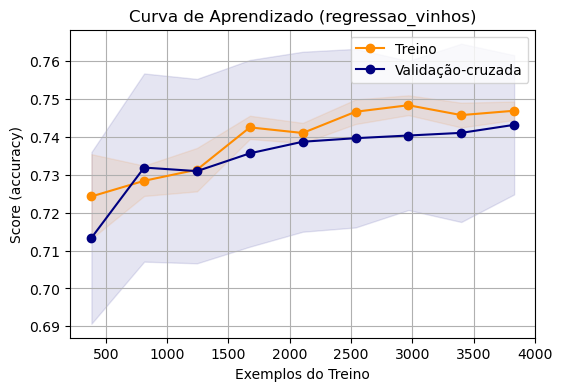

In [26]:
model_name = 'regressao_vinhos' # evitar espacos, -, e outros caracteres.
Y = df_wine[wine_target_col]
X = df_wine.drop(wine_target_col, axis=1)

# Configuracoes
penalty = 'l2'
C       = 1.0
solver = 'liblinear'

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[wine_target_col] = ytrain
df_test[wine_target_col] = ytest

with mlflow.start_run(experiment_id=experiment_id, run_name = 'LogArtefatos'):
    model_wine = linear_model.LogisticRegression(C=C, penalty = penalty, solver=solver)
    model_wine.fit(xtrain, ytrain)    
    df_train['decision'] = model_wine.predict(xtrain)
    df_test['decision']  = model_wine.predict(xtest)
    df_train['probability'] = model_wine.predict_proba(xtrain)[:,1]
    df_test['probability']  = model_wine.predict_proba(xtest)[:,1]
    
    (precision, recall, f1) = eval_metrics(df_test[wine_target_col], df_test['decision'])
    cm =  metrics.confusion_matrix(df_test[wine_target_col], df_test['decision'])

    print("Regressao Logistica (C=%f, penalty=%s):" % (C, penalty))
    print("  precision: %s" % precision)
    print("  recall: %s" % recall)
    print("  f1: %s" % f1)

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("C", C)
    mlflow.log_param("penalty", penalty)
    
    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("Verdadeiro Positivo",cm[1,1])
    mlflow.log_metric("Verdadeiro Negativo",cm[0,0])
    mlflow.log_metric("Falso Positivo",cm[0,1])
    mlflow.log_metric("Falso Negativo",cm[1,0])
    
    # LOG DE ARTEFATOS - ARQUIVOS COM IMAGENS, TABELAS, PICKLE...
    # Plot da curva de aprendizado
    train_sizes = np.linspace(0.1, 1, 9)
    plot_learning_curve(model_wine, model_name, 'accuracy', train_sizes)
    plot_path = f'plot_learning_{model_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    

# Auto - Log do Sklearn 

2024/03/25 18:34:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ciodaro/anaconda3/envs/infnet/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


Regressao Logistica (C=1.000000, penalty=l2):
  precision: 0.7669902912621359
  recall: 0.8290854572713643
  f1: 0.7968299711815563


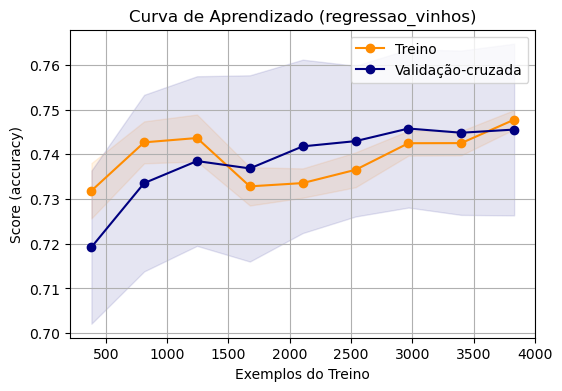

In [27]:
model_name = 'regressao_vinhos' # evitar espacos, -, e outros caracteres.
Y = df_wine[wine_target_col]
X = df_wine.drop(wine_target_col, axis=1)

# Configuracoes
penalty = 'l2'
C       = 1.0
solver = 'liblinear'

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[wine_target_col] = ytrain
df_test[wine_target_col] = ytest

with mlflow.start_run(experiment_id=experiment_id, run_name = 'LogAutomatico') as run:
    mlflow.sklearn.autolog() # Precisa ser chamado antes do codigo do treinamento
    
    # Treinamento
    model_wine = linear_model.LogisticRegression(C=C, penalty = penalty, solver=solver)
    model_wine.fit(xtrain, ytrain)    
    df_train['decision'] = model_wine.predict(xtrain)
    df_test['decision']  = model_wine.predict(xtest)
    df_train['probability'] = model_wine.predict_proba(xtrain)[:,1]
    df_test['probability']  = model_wine.predict_proba(xtest)[:,1]
    
    (precision, recall, f1) = eval_metrics(df_test[wine_target_col], df_test['decision'])
    cm =  metrics.confusion_matrix(df_test[wine_target_col], df_test['decision'])

    print("Regressao Logistica (C=%f, penalty=%s):" % (C, penalty))
    print("  precision: %s" % precision)
    print("  recall: %s" % recall)
    print("  f1: %s" % f1)

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("C", C)
    mlflow.log_param("penalty", penalty)
    
    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("Verdadeiro Positivo",cm[1,1])
    mlflow.log_metric("Verdadeiro Negativo",cm[0,0])
    mlflow.log_metric("Falso Positivo",cm[0,1])
    mlflow.log_metric("Falso Negativo",cm[1,0])
    
    # LOG DE ARTEFATOS - ARQUIVOS COM IMAGENS, TABELAS, PICKLE...
    train_sizes = np.linspace(0.1, 1, 9)
    plot_learning_curve(model_wine, model_name, 'accuracy', train_sizes)
    plot_path = f'plot_learning_{model_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    
    # ADICAO DE TAGS PARA IDENTIFICAR A RODADA
    mlflow_client.set_tag(run.info.run_id, "Rodada", "Automacao do log sklearn")
    mlflow_client.set_tag(run.info.run_id, "Teste", "Funcionamento do auto-log")
    mlflow_client.set_tag(run.info.run_id, "keywords", "automacao,sklearn,logging")
    

## MLFlow e PyCaret

In [9]:
pc.plot_model?

Object `pc.plot_model` not found.


In [29]:
import pycaret.classification as pc

experiment_name = 'automl-wine'

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)
df_train = xtrain.copy()
df_test = xtest.copy()
df_train[wine_target_col] = ytrain
df_test[wine_target_col] = ytest

# mlflow.set_tracking_uri("sqlite:///mlruns.db")

s = pc.setup(data = df_train, 
             target = wine_target_col,
             test_data=df_test,             
             log_experiment = True, 
             experiment_name = experiment_name, 
             log_plots = True)
models = ['lr', 'dt', 'rf']
bestmodel = pc.compare_models(include = models)

# plot: str, default = 'residual'
# [ 'auc', 'threshold','pr','confusion_matrix','error','class_report',
#                          'boundary','rfe','learning','manifold','calibration','vc','dimension',
#                          'feature','feature_all','parameter','lift','gain','tree','ks']
# Log do run, e nao do modelo respectivo
classification_plots = [
    'auc', 'confusion_matrix',
    # 'error','class_report'
    # 'threshold','pr',,
    # 'learning',
    # 'vc',
    'feature_all',
]
for plot_type in classification_plots:
    print('=> Aplicando plot ', plot_type)
    try:
        artifact = pc.plot_model(bestmodel, plot=plot_type, save=True) # use_train_data=False
        mlflow.log_artifact(artifact)
    except:
        print('=> Nao possivel plotar: ', plot_type )
        continue
        


,Description,Value
0,Session id,2189
1,Target,target
2,Target type,Binary
3,Original data shape,"(5320, 13)"
4,Transformed data shape,"(5320, 13)"
5,Transformed train set shape,"(4256, 13)"
6,Transformed test set shape,"(1064, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7723,0.8389,0.8469,0.8026,0.8241,0.5022,0.5039,0.1480
lr,Logistic Regression,0.7517,0.8089,0.8421,0.7808,0.8102,0.4525,0.4555,0.4520
dt,Decision Tree Classifier,0.6974,0.6769,0.7559,0.7618,0.7587,0.3528,0.3530,0.0220


=> Aplicando plot  auc


=> Aplicando plot  confusion_matrix


=> Aplicando plot  feature_all


# Execução de Projeto MLFlow 

In [31]:
import mlflow

experiment_name = 'wine-ml-model'
parameters = {
    'seed': 10,
    'experiment_name': experiment_name
}


mlflow.projects.run(uri = './', # path local ou projeto git
                    entry_point='main', # comando a executar do projeto
                    version=None, # Git branch ou commit para utilizar
                    parameters=parameters, # dicionario com os parametros definidos em MLproject
                    docker_args=None, # argumentos para implementacao docker
                    experiment_name=experiment_name, # nome do experimento que vai ser realizado
#                     experiment_id=None, # id do experimento
                    backend='local', # rodar localmente ou no databricks
                    backend_config=None, # configuracao do backend
                    
)


2024/03/25 18:37:50 INFO mlflow.utils.conda: Conda environment mlflow-01ca5edb0c1af7ade26e5fc7cb9eeaa3decc557f already exists.
2024/03/25 18:37:50 INFO mlflow.projects.utils: === Created directory /tmp/tmpjwqziwbm for downloading remote URIs passed to arguments of type 'path' ===
2024/03/25 18:37:50 INFO mlflow.projects.backend.local: === Running command 'source /home/ciodaro/anaconda3/bin/../etc/profile.d/conda.sh && conda activate mlflow-01ca5edb0c1af7ade26e5fc7cb9eeaa3decc557f 1>&2 && python ml_wine.py 10 wine-ml-model' in run with ID 'bf079acebeb24f01a632c15aa2377a06' === 


(5320, 14)
                    Description            Value
0                    Session id             5282
1                        Target           target
2                   Target type           Binary
3           Original data shape       (5320, 14)
4        Transformed data shape       (5320, 13)
5   Transformed train set shape       (4256, 13)
6    Transformed test set shape       (1064, 13)
7               Ignore features                1
8              Ordinal features                1
9              Numeric features               11
10         Categorical features                1
11                   Preprocess             True
12              Imputation type           simple
13           Numeric imputation             mean
14       Categorical imputation             mode
15     Maximum one-hot encoding               25
16              Encoding method             None
17               Fold Generator  StratifiedKFold
18                  Fold Number               10
19       

                       Model  Accuracy     AUC  Recall   Prec.      F1  \
rf  Random Forest Classifier    0.7594  0.8293  0.8394  0.7940  0.8156   
lr       Logistic Regression    0.7474  0.8015  0.8472  0.7764  0.8098   
dt  Decision Tree Classifier    0.6790  0.6539  0.7472  0.7474  0.7469   

     Kappa     MCC  TT (Sec)  
rf  0.4698  0.4727     0.156  
lr  0.4357  0.4408     0.328  
dt  0.3079  0.3085     0.023  
=> Aplicando plot  auc
=> Aplicando plot  confusion_matrix


2024/03/25 18:38:06 INFO mlflow.projects: === Run (ID 'bf079acebeb24f01a632c15aa2377a06') succeeded ===


In [ ]:
# mlflow.end_run()
# !mlflow ui
# Para usar o sqlite como repositorio
# mlflow ui --backend-store-uri sqlite:///mlruns.db